In [1]:
import numpy as np
import pandas as pd
import json
#!pip install ase
#from dscribe.descriptors import CoulombMatrix
from ase import Atoms
import matplotlib.pyplot as plt
import matplotlib


## Importing data from google drive


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')



In [3]:
data_dir = ''
# Loading the data as pandas DataFrame
train = pd.DataFrame(json.load(open(data_dir + "train.json", "rb")))
train = train[train.dynamic_stability_level != 1] # remove unstable
test = pd.DataFrame(json.load(open(data_dir + "test.json", "rb")))
## Transform atoms entry to ASE atoms object
train.atoms = train.atoms.apply(lambda x: Atoms(**x)) # OBS This one is important!
test.atoms = test.atoms.apply(lambda x: Atoms(**x))



In [4]:
train.head()

,formula,etot,dynamic_stability_level,atoms,Voigt_modulus
1,NiI2,-9.774512,2,"(Atom('Ni', [-7.814021732e-19, -1.673235808e-1...",31.358817
3,Hf4N3O2,-85.216280,3,"(Atom('Hf', [0.0, 1.8605461437, 11.1322923235]...",279.073400
6,Cr2Cl2Se2,-34.354062,3,"(Atom('Cr', [2.5217362911, 5.385447366e-16, 9....",47.686173
8,MoBrI,-13.552381,2,"(Atom('Mo', [1.543915598e-17, -1.192455131e-16...",15.989285
9,Tl2I6,-14.982825,2,"(Atom('Tl', [3.8955234015, 2.2490814845, 9.460...",5.012215


In [5]:
train.atoms[0]

Atoms(symbols='NiI2', pbc=[True, True, False], cell=[[3.8508521418, -5.484107923e-19, 0.0], [-1.9254260709, 3.3349357811, 0.0], [1.332689519e-18, 0.0, 18.3890325946]])

In [6]:
print('Train data shape: {}'.format(train.shape))
train.head()

Train data shape: (1559, 5)


,formula,etot,dynamic_stability_level,atoms,Voigt_modulus
1,NiI2,-9.774512,2,"(Atom('Ni', [-7.814021732e-19, -1.673235808e-1...",31.358817
3,Hf4N3O2,-85.216280,3,"(Atom('Hf', [0.0, 1.8605461437, 11.1322923235]...",279.073400
6,Cr2Cl2Se2,-34.354062,3,"(Atom('Cr', [2.5217362911, 5.385447366e-16, 9....",47.686173
8,MoBrI,-13.552381,2,"(Atom('Mo', [1.543915598e-17, -1.192455131e-16...",15.989285
9,Tl2I6,-14.982825,2,"(Atom('Tl', [3.8955234015, 2.2490814845, 9.460...",5.012215


In [7]:
def pad_with(vector, pad_width, iaxis, kwargs):
     pad_value = kwargs.get('padder', 10)
     vector[:pad_width[0]] = pad_value
     vector[-pad_width[1]:] = pad_value


def coulomb_matrix(atoms, n_atoms_max):
    # Creating a matrix with the product of the atomic numbers such that M_ij = Z[i]*Z[j]
    atomic_numbers = np.outer(atoms.get_atomic_numbers(),atoms.get_atomic_numbers())
    # Getting the distance matrix of the atoms object, such that element D_ij = |r_i - r_j|
    distances = atoms.get_all_distances()
    # Setting the diagonal elements, which are all zero, to 1 to avoid overflow errors
    np.fill_diagonal(distances, 1)
    
    # Creating the Cmat
    cmat = np.multiply(atomic_numbers, 1/distances) # Element wise multiplication
    np.fill_diagonal(cmat, 0.5*np.array(atoms.get_atomic_numbers())**2.4) # Filling the diagonal as described in the slides
    
    # Taking the sorted eigenvalues and padding with zeros such that all of the fingerprints have the same size
    shape = cmat.shape
    cmat,_ = np.linalg.eig(cmat)
    cmat = np.flip(np.sort(cmat))
    holder = np.zeros(n_atoms_max)
    holder[:shape[0]] = cmat
    cmat = holder
    
    return cmat

In [8]:
species = []
number_of_atoms = []
atomic_numbers = []
for atom in pd.concat([train.atoms,test.atoms]):
    species = list(set(species+atom.get_chemical_symbols()))
    atomic_numbers = list(set(atomic_numbers+list(atom.get_atomic_numbers())))
    number_of_atoms.append(atom.get_number_of_atoms())

max_number_of_atoms = np.max(number_of_atoms)
min_atomic_number = np.min(atomic_numbers)

print(max_number_of_atoms)

12


C:\software\anoconda\lib\site-packages\ase\atoms.py:971: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  warnings.warn('Use get_global_number_of_atoms() instead',


In [9]:
cmats = np.zeros((len(train),max_number_of_atoms))
for i,atoms in enumerate(train.atoms):
    if i%1000 == 0:
        print(i)
    cmat = coulomb_matrix(atoms,max_number_of_atoms)
    cmats[i,:] = cmat.flatten()
print(len(cmats))

0
1000
1559


In [10]:
X = pd.DataFrame(data = cmats, index=train.index)
y = train['Voigt_modulus']
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))

X: (1559, 12)
y: (1559,)


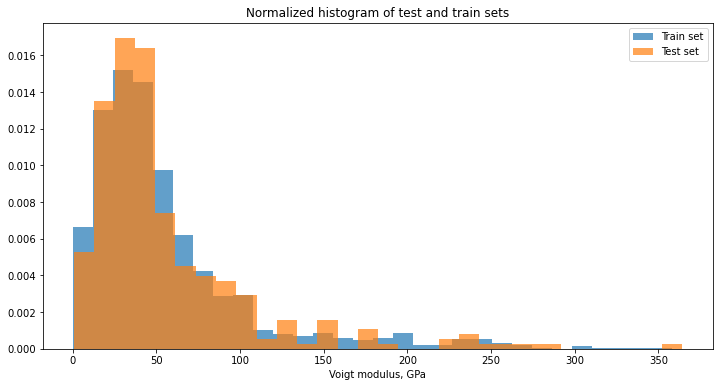

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
#random state 250
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.01)
#scaler = StandardScaler().fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)


plt.figure(figsize = (12, 6))
plt.hist(y_train, bins=30, alpha=0.7, density=True, label='Train set')
plt.hist(y_test, bins=30, alpha=0.7, density=True, label='Test set')

plt.title("Normalized histogram of test and train sets")
plt.xlabel("Voigt modulus, GPa")
plt.legend()
plt.show()

In [12]:
print('X_train: {}'.format(X_train.shape))
print('y_train: {}'.format(y_train.shape))
print('X_test: {}'.format(X_test.shape))
print('y_test: {}'.format(y_test.shape))

X_train: (1247, 12)
y_train: (1247,)
X_test: (312, 12)
y_test: (312,)


In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20,normalize_y=True)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X_train, y_train)




C:\software\anoconda\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=20, normalize_y=True)

In [14]:
# gp_noP = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20,normalize_y=False)
# gp_noP.fit(X_train, y_train)

In [15]:
gp.get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel__k1': 1**2,
 'kernel__k2': RBF(length_scale=1),
 'kernel__k1__constant_value': 1.0,
 'kernel__k1__constant_value_bounds': (0.001, 1000.0),
 'kernel__k2__length_scale': 1,
 'kernel__k2__length_scale_bounds': (0.01, 100.0),
 'kernel': 1**2 * RBF(length_scale=1),
 'n_restarts_optimizer': 20,
 'normalize_y': True,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

In [16]:
from sklearn.metrics import mean_squared_error as mse

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [17]:
train_prediction = gp.predict(X_train)
test_prediction = gp.predict(X_test)

In [18]:
print('Train RMSE = {:.2f}'.format(rmse(y_train,train_prediction)))
print('Test RMSE = {:.2f}'.format(rmse(y_test,test_prediction)))

Train RMSE = 0.08
Test RMSE = 50.18


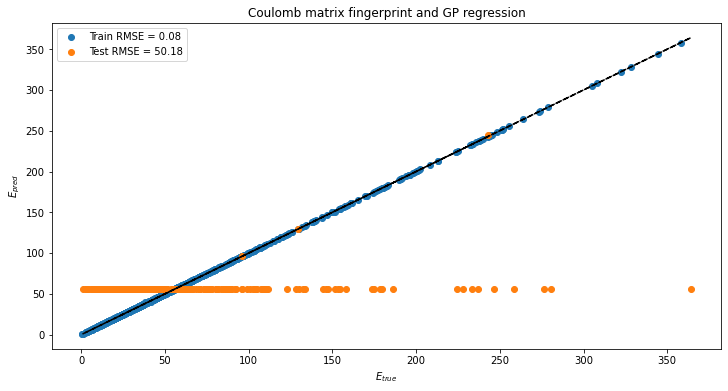

In [19]:
fig = plt.figure(figsize = (12, 6))

plt.title("Coulomb matrix fingerprint and GP regression")
plt.scatter(y_train, gp.predict(X_train), label = 'Train RMSE = {:.2f}'.format(rmse(y_train,train_prediction)))
plt.scatter(y_test, gp.predict(X_test), label = 'Test RMSE = {:.2f}'.format(rmse(y_test,test_prediction)))
plt.plot(y_test, y_test, linestyle = "--", color = "k")
plt.xlabel("$E_{true}$")
plt.ylabel("$E_{pred}$")
plt.legend()
plt.show()  

In [20]:
cmats_test = np.zeros((len(test),max_number_of_atoms))
for i,atoms in enumerate(test.atoms):
    if i%1000 == 0:
        print(i)
    cmat = coulomb_matrix(atoms,max_number_of_atoms)
    cmats_test[i,:] = cmat.flatten()




0


In [21]:
X_test_kaggle = pd.DataFrame(data = cmats_test, index=test.index)
print(X_test_kaggle.head())
X_test_kaggle.loc[:,:] = scaler.transform(X_test_kaggle)

             0            1            2           3          4          5   \
0   7239.873273  6001.878877   892.757174  666.358711   0.000000   0.000000   
1   1912.160496  1350.209177    72.880173   45.896580   0.000000   0.000000   
2   4080.241306  3015.814703  2791.543355   38.617453  24.982962   0.000000   
3   1048.979652   674.094258    84.285147   55.515745  54.039122  43.687835   
4  20284.696226  3982.509533  2043.563134    0.000000   0.000000   0.000000   

    6    7    8    9    10   11  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  


NameError: name 'scaler' is not defined

In [ ]:
X_test_kaggle.head()

In [ ]:
test_prediction_dataframe = pd.DataFrame(data = {'ID':test.index,
                                                 'Voigt_modulus':gp.predict(X_test_kaggle)})
test_prediction_dataframe.head()